# not-MIWAE: Deep Generative Modelling with Missing not at Random Data
This notebook illustrates how to fit a *deep latent variable model* to data affected by a missing process which depends on the missing data itself, i.e. *missing not at random*.

We fit a linear PPCA-like model to a relatively small UCI dataset.

### Preamble

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import keras
import matplotlib.pyplot as plt
import pandas as pd
import time

# import sys
# sys.path.append('./')

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "6"

plt.rcParams["font.family"] = "serif"
plt.rcParams['font.size'] = 15.0
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['savefig.format'] = 'pdf'
plt.rcParams['lines.linewidth'] = 2.5


/home/nbip/miniconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/nbip/miniconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/nbip/miniconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/nbip/miniconda3/envs/python36/lib/pyt

### Load data
Here we use the white-wine dataset from the UCI database

In [2]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv"
data = np.array(pd.read_csv(url, low_memory=False, sep=';'))
# ---- drop the classification attribute
data = data[:, :-1]

### Settings

In [3]:
N, D = data.shape
n_latent = D - 1
n_hidden = 128
n_samples = 20
max_iter = 30000
batch_size = 16

### Standardize data

In [4]:
# ---- standardize data
data = data - np.mean(data, axis=0)
data = data / np.std(data, axis=0)

# ---- random permutation 
p = np.random.permutation(N)
data = data[p, :]

# ---- we use the full dataset for training here, but you can make a train-val split
Xtrain = data.copy()
Xval = Xtrain.copy()

### Introduce missing 
Here we denote
- Xnan: data matrix with np.nan as the missing entries
- Xz: data matrix with 0 as the missing entries
- S: missing mask 

The missing process depends on the missing data itself:
- in half the features, set the feature value to missing when it is higher than the feature mean

In [5]:
# ---- introduce missing process
Xnan = Xtrain.copy()
Xz = Xtrain.copy()

mean = np.mean(Xnan[:, :int(D / 2)], axis=0)
ix_larger_than_mean = Xnan[:, :int(D / 2)] > mean

Xnan[:, :int(D / 2)][ix_larger_than_mean] = np.nan
Xz[:, :int(D / 2)][ix_larger_than_mean] = 0

S = np.array(~np.isnan(Xnan), dtype=np.float32)

### Build the model
The model we are building has a Gaussian prior and a Gaussian observation model,

$$ p(\mathbf{z}) = \mathcal{N}(\mathbf{z} | \mathbf{0}, \mathbf{I})$$

$$ p(\mathbf{x} | \mathbf{z}) = \mathcal{N}(\mathbf{x} | \mathbf{\mu}_{\theta}(\mathbf{z}), \sigma^2\mathbf{I})$$

$$ p(\mathbf{x}) = \int p(\mathbf{x} | \mathbf{z})p(\mathbf{z}) d\mathbf{z}$$

where $\mathbf{\mu}_{\theta}(\mathbf{z}): \mathbb{R}^d \rightarrow \mathbb{R}^p $ in general is a deep neural net, but in this case is a linear mapping, $\mathbf{\mu} = \mathbf{Wz + b}$.

The variational posterior is also Gaussian

$$q_{\gamma}(\mathbf{z} | \mathbf{x}) = \mathcal{N}(\mathbf{z} | \mu_{\gamma}(\mathbf{x}), \sigma_{\gamma}(\mathbf{x})^2 \mathbf{I})$$

If the missing process is *missing at random*, it is ignorable and the ELBO becomes, as described in [the MIWAE paper](https://arxiv.org/abs/1812.02633)

$$ E_{\mathbf{z}_1...\mathbf{z}_K} \left[ \log \frac{1}{K}\sum_{k=1}^K \frac{p_{\theta}(\mathbf{x^o} | \mathbf{z}_k)p(\mathbf{z}_k)}{q_{\gamma}(\mathbf{z}_k | \mathbf{x^o})} \right] $$

When the missing process is MNAR it is non-ignorable and we need to include the missing model. In this example we include the missing model as a logistic regression in each feature dimension

$$ p_{\phi}(\mathbf{s} | \mathbf{x^o, x^m}) = \text{Bern}(\mathbf{s} | \pi_{\phi}(\mathbf{x^o, x^m}))$$

$$ \pi_{\phi, j}(x_j) = \frac{1}{1 + e^{-\text{logits}_j}} $$

$$ \text{logits}_j = W_j (x_j - b_j) $$

The ELBO in the MNAR case becomes

$$ E_{(\mathbf{z}_1, \mathbf{x}_1^m)...(\mathbf{z}_K, \mathbf{x}_K^m)} \left[ \log \frac{1}{K} \sum_{k=1}^K \frac{p_{\phi}(\mathbf{s} | \mathbf{x}^o, \mathbf{x}_k^m) p_{\theta}(\mathbf{x}^o | \mathbf{z}_k) p(\mathbf{z}_k)}{q_{\gamma}(\mathbf{z} | \mathbf{x}^o)} \right]$$


### Inputs
Let's first define the inputs of the model
- x_pl: data input
- s_pl: mask input
- n_pl: number of importance samples

In [6]:
print("Creating graph...")
tf.reset_default_graph()
# ---- input
with tf.variable_scope('input'):
    x_pl = tf.placeholder(tf.float32, [None, D], 'x_pl')
    s_pl = tf.placeholder(tf.float32, [None, D], 's_pl')
    n_pl = tf.placeholder(tf.int32, shape=(), name='n_pl')

Creating graph...


the noise variance is learned as a shared parameter

In [7]:
# ---- parameters
with tf.variable_scope('data_process'):
    logstd = tf.get_variable('logstd', shape=[])

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


### Encoder
The encoder / inference network consists of two hidden layers with 128 units and tanh activation

In [8]:
x = keras.layers.Dense(units=n_hidden, activation=tf.nn.tanh, name='l_enc1')(x_pl)
x = keras.layers.Dense(units=n_hidden, activation=tf.nn.tanh, name='l_enc2')(x)

q_mu = keras.layers.Dense(units=n_latent, activation=None, name='q_mu')(x)

q_logstd = keras.layers.Dense(units=n_latent, activation=lambda x: tf.clip_by_value(x, -10, 10),
                           name='q_logstd')(x)

### Variational distribution

In [9]:
q_z = tfp.distributions.Normal(loc=q_mu, scale=tf.exp(q_logstd))

# ---- sample the latent value
l_z = q_z.sample(n_pl)                    # shape [n_samples, batch_size, dl]
l_z = tf.transpose(l_z, perm=[1, 0, 2])   # shape [batch_size, n_samples, dl]

### Decoder

In [10]:
mu = keras.layers.Dense(units=D, activation=None, name='mu')(l_z)

### Observation model / likelihood function

In [11]:
p_x_given_z = tfp.distributions.Normal(loc=mu, scale=tf.exp(logstd))

### Missing model
- first mix observed data and samples of missing data
- feed through missing model
- find likelihood of missing model parameters

We have to expand the dimensions of x_pl and s_pl, since mu has size [batch, n_samples, D]

In [12]:
l_out_mixed = mu * tf.expand_dims(1 - s_pl, axis=1) + tf.expand_dims(x_pl * s_pl, axis=1)

In [13]:
W = tf.get_variable('W', shape=[1, 1, D])
W = -tf.nn.softplus(W)
b = tf.get_variable('b', shape=[1, 1, D])

logits = W * (l_out_mixed - b)

p_s_given_x = tfp.distributions.Bernoulli(logits=logits)

### Evaluating likelihoods

In [14]:
# ---- evaluate the observed data in p(x|z)
log_p_x_given_z = tf.reduce_sum(tf.expand_dims(s_pl, axis=1) * 
                                p_x_given_z.log_prob(tf.expand_dims(x_pl, axis=1)), axis=-1)  # sum over d-dimension

# --- evaluate the z-samples in q(z|x)
q_z2 = tfp.distributions.Normal(loc=tf.expand_dims(q_z.loc, axis=1), scale=tf.expand_dims(q_z.scale, axis=1))
log_q_z_given_x = tf.reduce_sum(q_z2.log_prob(l_z), axis=-1)

# ---- evaluate the z-samples in the prior p(z)
prior = tfp.distributions.Normal(loc=0.0, scale=1.0)
log_p_z = tf.reduce_sum(prior.log_prob(l_z), axis=-1)

# ---- evaluate the mask in p(s|x)
log_p_s_given_x = tf.reduce_sum(p_s_given_x.log_prob(tf.expand_dims(s_pl, axis=1)), axis=-1)


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


### Losses for the MIWAE and not-MIWAE respectively

In [15]:
lpxz = log_p_x_given_z
lpz = log_p_z
lqzx = log_q_z_given_x
lpsx = log_p_s_given_x

# ---- MIWAE
# ---- importance weights
l_w = lpxz + lpz - lqzx

# ---- sum over samples
log_sum_w = tf.reduce_logsumexp(l_w, axis=1)

# ---- average over samples
log_avg_weight = log_sum_w - tf.log(tf.cast(n_pl, tf.float32))

# ---- average over minibatch to get the average llh
MIWAE = tf.reduce_mean(log_avg_weight, axis=-1)


# ---- not-MIWAE
# ---- importance weights
l_w = lpxz + lpsx + lpz - lqzx

# ---- sum over samples
log_sum_w = tf.reduce_logsumexp(l_w, axis=1)

# ---- average over samples
log_avg_weight = log_sum_w - tf.log(tf.cast(n_pl, tf.float32))

# ---- average over minibatch to get the average llh
notMIWAE = tf.reduce_mean(log_avg_weight, axis=-1)


### Training stuff

In [16]:
# ---- training stuff
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
global_step = tf.Variable(initial_value=0, trainable=False)
optimizer = tf.train.AdamOptimizer()

### Choose wether you want to train the MIWAE or the notMIWAE

In [17]:
loss = -notMIWAE
# loss = -MIWAE

tvars = tf.trainable_variables()
train_op = optimizer.minimize(loss, global_step=global_step, var_list=tvars)
sess.run(tf.global_variables_initializer())

### Do the training

In [18]:
batch_pointer = 0

start = time.time()
best = float("inf")


for i in range(max_iter):
    x_batch = Xz[batch_pointer: batch_pointer + batch_size, :]
    s_batch = S[batch_pointer: batch_pointer + batch_size, :]

    _, _loss, _step = sess.run([train_op, loss, global_step], {x_pl: x_batch, s_pl: s_batch, n_pl: n_samples})

    batch_pointer += batch_size
    
    if batch_pointer > N - batch_size:
        batch_pointer = 0

        p = np.random.permutation(N)
        Xz = Xz[p, :]
        S = S[p, :]
    
    if i % 100 == 0:
        took = time.time() - start
        start = time.time()
        
        # --- change the following batch if you want a true validation set
        x_batch = Xz  
        s_batch = S
        
        val_loss, _step = sess.run([loss, global_step], {x_pl: x_batch, s_pl: s_batch, n_pl: n_samples})

        print("{0}/{1} updates, {2:.2f} s, {3:.2f} train_loss, {4:.2f} val_loss".format(i, max_iter, took, _loss, val_loss))



0/30000 updates, 0.48 s, 21.12 train_loss, 21.61 val_loss
100/30000 updates, 0.39 s, 20.42 train_loss, 20.17 val_loss
200/30000 updates, 0.30 s, 19.16 train_loss, 19.21 val_loss
300/30000 updates, 0.31 s, 18.26 train_loss, 18.44 val_loss
400/30000 updates, 0.33 s, 17.41 train_loss, 17.78 val_loss
500/30000 updates, 0.34 s, 16.48 train_loss, 17.30 val_loss
600/30000 updates, 0.37 s, 16.70 train_loss, 16.89 val_loss
700/30000 updates, 0.35 s, 16.92 train_loss, 16.59 val_loss
800/30000 updates, 0.38 s, 16.20 train_loss, 16.22 val_loss
900/30000 updates, 0.38 s, 15.79 train_loss, 15.92 val_loss
1000/30000 updates, 0.35 s, 14.78 train_loss, 15.69 val_loss
1100/30000 updates, 0.39 s, 14.25 train_loss, 15.48 val_loss
1200/30000 updates, 0.37 s, 15.40 train_loss, 15.24 val_loss
1300/30000 updates, 0.37 s, 14.81 train_loss, 15.07 val_loss
1400/30000 updates, 0.37 s, 15.50 train_loss, 14.83 val_loss
1500/30000 updates, 0.37 s, 14.10 train_loss, 14.63 val_loss
1600/30000 updates, 0.33 s, 14.95 tr

13400/30000 updates, 0.31 s, 11.72 train_loss, 11.53 val_loss
13500/30000 updates, 0.33 s, 11.52 train_loss, 11.53 val_loss
13600/30000 updates, 0.32 s, 11.57 train_loss, 11.52 val_loss
13700/30000 updates, 0.33 s, 11.00 train_loss, 11.51 val_loss
13800/30000 updates, 0.28 s, 11.71 train_loss, 11.50 val_loss
13900/30000 updates, 0.30 s, 10.65 train_loss, 11.49 val_loss
14000/30000 updates, 0.29 s, 10.99 train_loss, 11.51 val_loss
14100/30000 updates, 0.31 s, 12.16 train_loss, 11.50 val_loss
14200/30000 updates, 0.36 s, 13.33 train_loss, 11.48 val_loss
14300/30000 updates, 0.35 s, 12.58 train_loss, 11.49 val_loss
14400/30000 updates, 0.35 s, 11.10 train_loss, 11.48 val_loss
14500/30000 updates, 0.34 s, 11.47 train_loss, 11.53 val_loss
14600/30000 updates, 0.34 s, 10.57 train_loss, 11.52 val_loss
14700/30000 updates, 0.34 s, 11.30 train_loss, 11.49 val_loss
14800/30000 updates, 0.34 s, 11.46 train_loss, 11.59 val_loss
14900/30000 updates, 0.35 s, 13.10 train_loss, 11.48 val_loss
15000/30

26700/30000 updates, 0.37 s, 10.83 train_loss, 11.49 val_loss
26800/30000 updates, 0.34 s, 11.80 train_loss, 11.45 val_loss
26900/30000 updates, 0.34 s, 10.30 train_loss, 11.42 val_loss
27000/30000 updates, 0.36 s, 12.08 train_loss, 11.40 val_loss
27100/30000 updates, 0.31 s, 11.63 train_loss, 11.43 val_loss
27200/30000 updates, 0.34 s, 11.83 train_loss, 11.78 val_loss
27300/30000 updates, 0.34 s, 10.94 train_loss, 11.45 val_loss
27400/30000 updates, 0.31 s, 11.50 train_loss, 11.41 val_loss
27500/30000 updates, 0.33 s, 10.76 train_loss, 11.38 val_loss
27600/30000 updates, 0.30 s, 12.25 train_loss, 11.43 val_loss
27700/30000 updates, 0.30 s, 11.20 train_loss, 11.45 val_loss
27800/30000 updates, 0.28 s, 11.67 train_loss, 11.38 val_loss
27900/30000 updates, 0.34 s, 12.55 train_loss, 11.46 val_loss
28000/30000 updates, 0.37 s, 11.23 train_loss, 11.38 val_loss
28100/30000 updates, 0.34 s, 10.60 train_loss, 11.39 val_loss
28200/30000 updates, 0.34 s, 11.60 train_loss, 11.38 val_loss
28300/30

### Single imputation RMSE
The *self-normalized importance sampling* approach for the MIWAE is described in this [paper](https://arxiv.org/pdf/1812.02633.pdf). This needs to be modified slightly in the MNAR case to account for the missing model, as described in the not-MIWAE paper

In [19]:
def imputationRMSE(sess, Xorg, Xnan, L):

    N = len(Xorg)
    
    Xz = Xnan.copy()
    Xz[np.isnan(Xnan)] = 0
    S = np.array(~np.isnan(Xnan), dtype=np.float32)

    def softmax(x):
        e_x = np.exp(x - np.max(x, axis=1)[:, None])
        return e_x / e_x.sum(axis=1)[:, None]

    def imp(xz, s, L):
        _mu, _log_p_x_given_z, _log_p_z, _log_q_z_given_x = sess.run(
            [mu, log_p_x_given_z, log_p_z, log_q_z_given_x],
            {x_pl: xz, s_pl: s, n_pl: L})

        wl = softmax(_log_p_x_given_z + _log_p_z - _log_q_z_given_x)

        xm = np.sum((_mu.T * wl.T).T, axis=1)
        xmix = xz + xm * (1 - s)

        return _mu, wl, xm, xmix

    XM = np.zeros_like(Xorg)

    for i in range(N):

        xz = Xz[i, :][None, :]
        s = S[i, :][None, :]

        _mu, wl, xm, xmix = imp(xz, s, L)

        XM[i, :] = xm

        if i % 100 == 0:
            print('{0} / {1}'.format(i, N))

    return np.sqrt(np.sum((Xorg - XM) ** 2 * (1 - S)) / np.sum(1 - S)), XM


def not_imputationRMSE(sess, Xorg, Xnan, L):

    N = len(Xorg)
    
    Xz = Xnan.copy()
    Xz[np.isnan(Xnan)] = 0
    S = np.array(~np.isnan(Xnan), dtype=np.float32)

    def softmax(x):
        e_x = np.exp(x - np.max(x, axis=1)[:, None])
        return e_x / e_x.sum(axis=1)[:, None]

    def imp(xz, s, L):
        _mu, _log_p_x_given_z, _log_p_z, _log_q_z_given_x, _log_p_s_given_x  = sess.run(
            [mu, log_p_x_given_z, log_p_z, log_q_z_given_x, log_p_s_given_x],
            {x_pl: xz, s_pl: s, n_pl: L})

        wl = softmax(_log_p_x_given_z + _log_p_s_given_x + _log_p_z - _log_q_z_given_x)

        xm = np.sum((_mu.T * wl.T).T, axis=1)
        xmix = xz + xm * (1 - s)

        return _mu, wl, xm, xmix

    XM = np.zeros_like(Xorg)

    for i in range(N):

        xz = Xz[i, :][None, :]
        s = S[i, :][None, :]

        _mu, wl, xm, xmix = imp(xz, s, L)

        XM[i, :] = xm

        if i % 100 == 0:
            print('{0} / {1}'.format(i, N))

    return np.sqrt(np.sum((Xorg - XM) ** 2 * (1 - S)) / np.sum(1 - S)), XM


### Calculate the single imputation RMSE using 10k importance samples
If you used the MIWAE loss use the imputationRMSE 

If you used the notMIWAE loss use the not_imputationRMSE

In [20]:
# ---- S has been permuted during training, so just reinstantiate it
S = np.array(~np.isnan(Xnan), dtype=np.float32)

rmse, imputations = not_imputationRMSE(sess, Xtrain, Xnan, 10000)
# rmse, imputations = imputationRMSE(sess, Xtrain, Xnan, 10000)

print("imputation RMSE: ", rmse)

0 / 4898
100 / 4898
200 / 4898
300 / 4898
400 / 4898
500 / 4898
600 / 4898
700 / 4898
800 / 4898
900 / 4898
1000 / 4898
1100 / 4898
1200 / 4898
1300 / 4898
1400 / 4898
1500 / 4898
1600 / 4898
1700 / 4898
1800 / 4898
1900 / 4898
2000 / 4898
2100 / 4898
2200 / 4898
2300 / 4898
2400 / 4898
2500 / 4898
2600 / 4898
2700 / 4898
2800 / 4898
2900 / 4898
3000 / 4898
3100 / 4898
3200 / 4898
3300 / 4898
3400 / 4898
3500 / 4898
3600 / 4898
3700 / 4898
3800 / 4898
3900 / 4898
4000 / 4898
4100 / 4898
4200 / 4898
4300 / 4898
4400 / 4898
4500 / 4898
4600 / 4898
4700 / 4898
4800 / 4898
imputation RMSE:  1.035147088721874


### Compare to missForest and MICE

In [21]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor

In [22]:
estimator = RandomForestRegressor(n_estimators=100)
imp = IterativeImputer(estimator=estimator)
imp.fit(Xnan)
Xrec = imp.transform(Xnan)
rmse_mf = np.sqrt(np.sum((Xtrain - Xrec) ** 2 * (1 - S)) / np.sum(1 - S))

/home/nbip/miniconda3/envs/python36/lib/python3.6/site-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


In [23]:
print("missForst imputation RMSE: ", rmse_mf)

missForst imputation RMSE:  1.6231575357178838


In [24]:
imp = IterativeImputer(max_iter=100)
imp.fit(Xnan)
Xrec = imp.transform(Xnan)
RMSE_iter = np.sqrt(np.sum((Xtrain - Xrec) ** 2 * (1 - S)) / np.sum(1 - S))

In [25]:
print("MICE, imputation RMSE", RMSE_iter)

MICE, imputation RMSE 1.4102763723316918


### Inspect the learned missing model
There is a separate missing process in each feature dimesion, inspect each of them, plot as function of feature value.

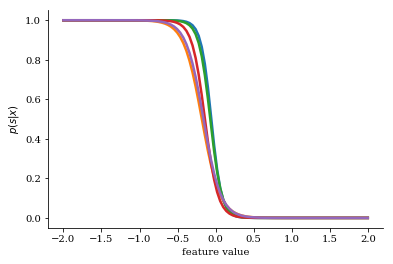

In [26]:
_W, _b = sess.run([W, b])
x = np.linspace(-2, 2, 100)

def sigmoid(logits):
    return 1 / (1 + np.exp(-logits))


plt.figure()

for d in range(D // 2):
    logits = _W[0][0][d] * (x - _b[0][0][d])
    psx = sigmoid(logits)
    plt.plot(x, psx)
    
plt.xlabel('feature value')
plt.ylabel('$p(s|x)$')
plt.show()
plt.close()

This should illustrate that the probability of the feature value being observed when it is below the feature mean should be close to 1, while the probability of being observed above the feature mean should be close to 0.

### Close the session

In [ ]:
# sess.close()